In [12]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import src.seed as seed
import src.models as models
import src.functions as fn

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots
# needs kaleido to work 
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+png"

In [2]:
device = seed.device
generator = seed.generator

X, y, X_test, y_test = fn.load_cifar_10()

Files already downloaded and verified
Files already downloaded and verified


C:\Users\Eric\DSC Capstone\Investigating-NN-Optimizers\src\functions.py:82: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)
  X = torch.tensor(X, dtype=torch.float32, device=device)


In [3]:
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# Model Parameters
input_size = X.shape[1] * X.shape[2] * X.shape[3]
num_hidden_layers = 2
hidden_layer_size = 200

output_dir = "eos/sgd_EC"
num_labels = 10

In [5]:
# Dataloader for SGD
batch_size = 128

train_dataset = TensorDataset(X, y)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=seed.cpu_generator
)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Single Model Tests

In [6]:
# Training Parameters
epochs = 2000
learning_rate = 0.1
accuracy = 0.999

model = models.FullyConnectedNet(
    input_size=input_size,
    num_hidden_layers=num_hidden_layers,
    hidden_layer_size=hidden_layer_size,
    num_labels=10,
    activation=nn.Tanh
)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0)

# Train with mini-batch SGD, compute Hessian on full batch
fn.train_sgd_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    accuracy=accuracy,
    train_loader=train_loader,
    test_loader=test_loader,
    X=X,
    y=y,
    output_dir=output_dir
)

Training FullyConnectedNet with SGD and learning rate 0.1 for 2000 epochs.
Completed training of FullyConnectedNet with SGD and learning rate 0.1. Took 341 epoches and 21.34 seconds. Final training accuracy: 0.9992; Final testing accuracy: 0.2590
Saved with model_id 14


In [7]:
md, out = fn.load_output_files(output_dir)

In [8]:
out = out[out['model_id']==11]

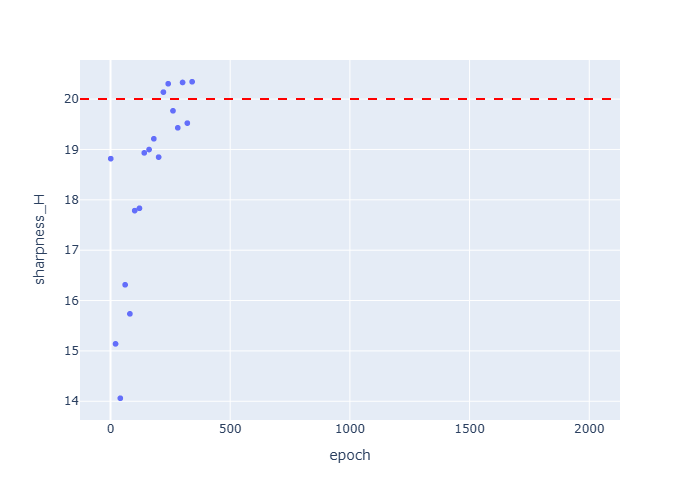

In [13]:
import plotly.express as px

fig = px.scatter(out, x='epoch', y='sharpness_H')
fig.add_hline(y=2/learning_rate, line_dash="dash", line_color="red")
fig.show()

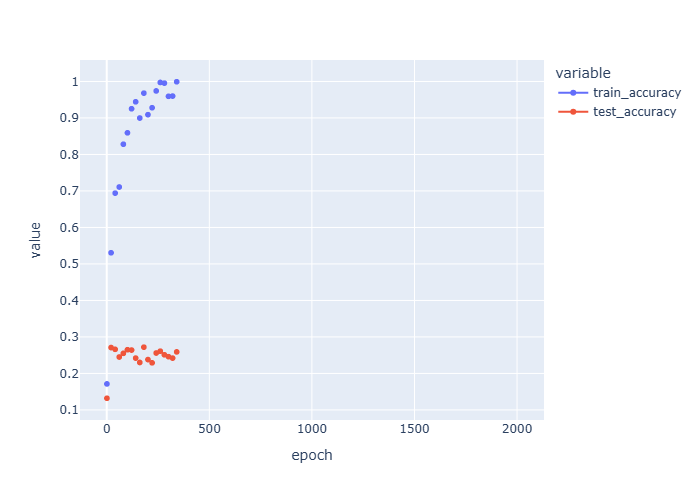

In [14]:
fig = px.line(
    out,
    x="epoch",
    y=["train_accuracy", "test_accuracy"],
    markers=True,
)

fig.show()

# Multi-Model Tests

In [ ]:
# Using the training params as above (minus lr)
epochs = 2000
accuracy = 0.999
model = models.FullyConnectedNet(
    input_size=input_size,
    num_hidden_layers=num_hidden_layers,
    hidden_layer_size=hidden_layer_size,
    num_labels=10,
    activation=nn.Tanh
)
criterion = nn.MSELoss()

# custom lr list
learning_rate_list = [0.05, 0.07, .1, .3, .5]
for lr in learning_rate_list:
    # Use optimizer with lr
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.0)
    
    # Train model
    fn.train_sgd_model(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        accuracy=accuracy,
        train_loader=train_loader,
        test_loader=test_loader,
        X=X,
        y=y,
        output_dir=output_dir
    )

In [ ]:
md, out = fn.load_output_files(output_dir)

In [ ]:
fig = px.scatter(out[out['model_id']==5], x='epoch', y='sharpness_H')
fig.add_hline(y=2/0.05, line_dash="dash", line_color="red")
fig.show()

In [ ]:
fig = px.scatter(out[out['model_id']==6], x='epoch', y='sharpness_H')
fig.add_hline(y=2/0.07, line_dash="dash", line_color="red")
fig.show()

In [ ]:
fig = px.scatter(out[out['model_id']==7], x='epoch', y='sharpness_H')
fig.add_hline(y=2/0.1, line_dash="dash", line_color="red")
fig.show()